In [1]:
import torch
from torch import nn

import model_predict

In [2]:
series, scaler = model_predict.read_data_series(scale=True, file_index=2)

时间序列不连贯，缺失的月份： ['2013-11', '2014-12', '2015-04', '2017-12']
即将填充缺失的月份
月份平均：
月份
1     165.417333
2     107.969333
3      95.301778
4     123.181000
5     154.631111
6     202.507111
7     136.807500
8     117.749000
9     157.433000
10    156.723500
11    156.563429
12    136.816000
Name: 销量（箱）, dtype: float64


In [3]:
# 4.1 LSTM 模型
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)
        self.init_weights()

    def forward(self, x):
        out, _ = self.lstm(x)
        out = self.fc(out[:, -1, :])  # 使用最后一个时间步的输出
        return out

    def init_weights(self):
        # 遍历 LSTM 层的参数，对参数进行初始化
        for name, param in self.named_parameters():
            if 'weight' in name:
                nn.init.normal_(param, mean=0, std=0.1)  # 使用正态分布初始化权重
            elif 'bias' in name:
                nn.init.constant_(param, 0)  # 将偏置项初始化为零
                
model_parameters = {
    "input_size": 3, "hidden_size": 24, "num_layers": 1, "output_size": 1
}

In [4]:
from importlib import reload
reload(model_predict)
model_predict.train_rnn_model(LSTMModel, model_parameters, series, test_shuffle=True, test_size=24, epochs=500)

训练 LSTMModel 模型
结果保存到： LSTMModel_best.pth
Epoch [50/500], Learn Rate: 1.0000e-03, Training Loss: 0.4695, Validation Loss: 1.3275
Epoch [100/500], Learn Rate: 1.0000e-03, Training Loss: 0.2367, Validation Loss: 1.5143
Epoch [150/500], Learn Rate: 1.0000e-03, Training Loss: 0.0958, Validation Loss: 1.6570
Epoch [200/500], Learn Rate: 1.0000e-03, Training Loss: 0.0402, Validation Loss: 1.6622
Epoch [250/500], Learn Rate: 1.0000e-03, Training Loss: 0.0195, Validation Loss: 1.6896
Epoch [300/500], Learn Rate: 1.0000e-03, Training Loss: 0.0107, Validation Loss: 1.6837
Epoch [350/500], Learn Rate: 1.0000e-03, Training Loss: 0.0065, Validation Loss: 1.6516
Epoch [400/500], Learn Rate: 1.0000e-03, Training Loss: 0.0043, Validation Loss: 1.6328
Epoch [450/500], Learn Rate: 1.0000e-03, Training Loss: 0.0028, Validation Loss: 1.6186
Epoch [500/500], Learn Rate: 1.0000e-03, Training Loss: 0.0016, Validation Loss: 1.6237
Best Validation Loss: 1.327519953250885


从2016年10月开始后续数据推理
MSE: 11766.63
MAE: 88.21
R^2: -1.65
MAPE: 0.76


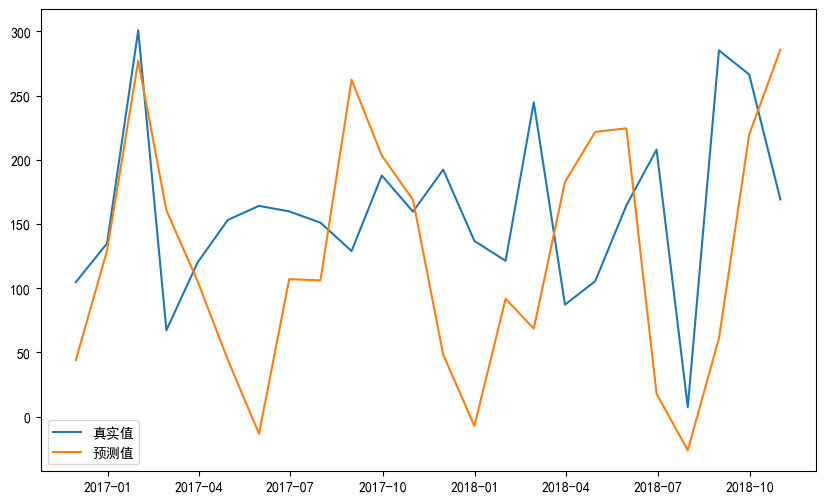

2016-11-30     44.031698
2016-12-31    129.293333
2017-01-31    277.057918
2017-02-28    160.625640
2017-03-31    105.425965
2017-04-30     44.343051
2017-05-31    -13.372666
2017-06-30    107.075793
2017-07-31    106.106443
2017-08-31    262.287504
2017-09-30    203.298336
2017-10-31    168.829371
2017-11-30     48.297401
2017-12-31     -7.277559
2018-01-31     91.766026
2018-02-28     68.511690
2018-03-31    182.736350
2018-04-30    221.693270
2018-05-31    224.475462
2018-06-30     17.847444
2018-07-31    -26.179650
2018-08-31     61.043709
2018-09-30    219.489928
2018-10-31    285.735013
Freq: M, dtype: float64

In [5]:
model = model_predict.load_rnn_model_best(LSTMModel, model_parameters)
model_predict.predict_to_future_rnn(model, series, scaler, last_months=32)